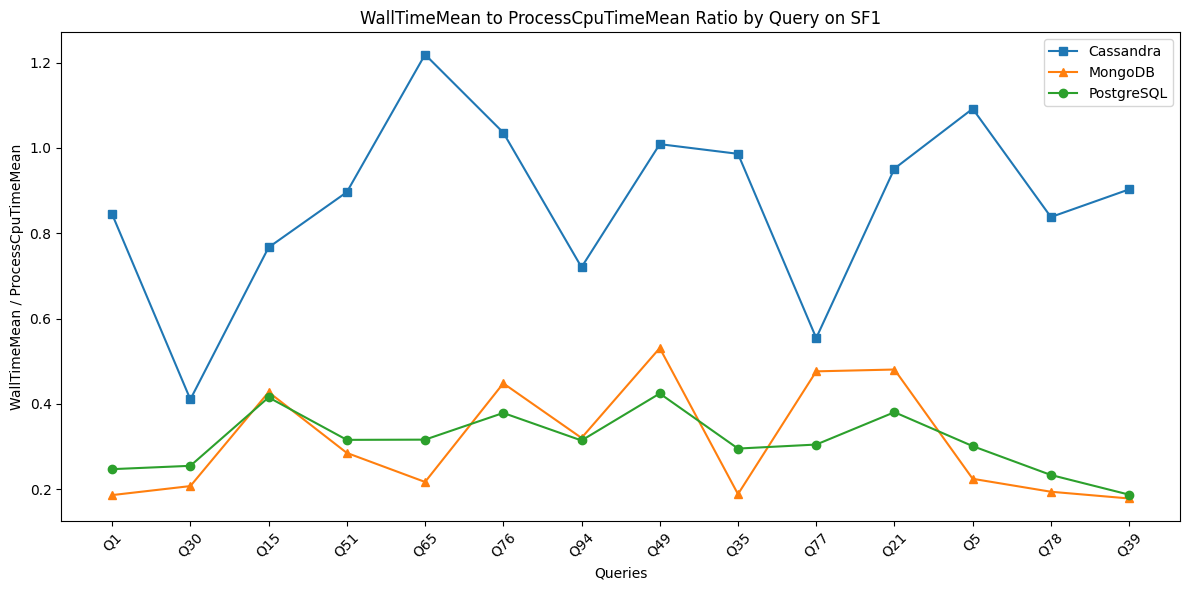

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Data for Cassandra
data_cassandra = [
    {"suite": "tpcds_cassandra_sf1", "query": "Q1", "wallTimeMean": 6205, "processCpuTimeMean": 7346},
    {"suite": "tpcds_cassandra_sf1", "query": "Q30", "wallTimeMean": 3601, "processCpuTimeMean": 8776},
    {"suite": "tpcds_cassandra_sf1", "query": "Q15", "wallTimeMean": 12777, "processCpuTimeMean": 16663},
    {"suite": "tpcds_cassandra_sf1", "query": "Q51", "wallTimeMean": 34116, "processCpuTimeMean": 38056},
    {"suite": "tpcds_cassandra_sf1", "query": "Q65", "wallTimeMean": 50374, "processCpuTimeMean": 41316},
    {"suite": "tpcds_cassandra_sf1", "query": "Q76", "wallTimeMean": 45860, "processCpuTimeMean": 44263},
    {"suite": "tpcds_cassandra_sf1", "query": "Q94", "wallTimeMean": 13413, "processCpuTimeMean": 18620},
    {"suite": "tpcds_cassandra_sf1", "query": "Q49", "wallTimeMean": 46864, "processCpuTimeMean": 46446},
    {"suite": "tpcds_cassandra_sf1", "query": "Q35", "wallTimeMean": 60553, "processCpuTimeMean": 61393},
    {"suite": "tpcds_cassandra_sf1", "query": "Q77", "wallTimeMean": 45466, "processCpuTimeMean": 82030},
    {"suite": "tpcds_cassandra_sf1", "query": "Q21", "wallTimeMean": 87765, "processCpuTimeMean": 92216},
    {"suite": "tpcds_cassandra_sf1", "query": "Q5", "wallTimeMean": 53210, "processCpuTimeMean": 48723},
    {"suite": "tpcds_cassandra_sf1", "query": "Q78", "wallTimeMean": 47000, "processCpuTimeMean": 56083},
    {"suite": "tpcds_cassandra_sf1", "query": "Q39", "wallTimeMean": 201056, "processCpuTimeMean": 222663},
]

# Data for MongoDB
data_mongodb = [
    {"suite": "tpcds_mongodb_sf1", "query": "Q1", "wallTimeMean": 1141, "processCpuTimeMean": 6140},
    {"suite": "tpcds_mongodb_sf1", "query": "Q30", "wallTimeMean": 1270, "processCpuTimeMean": 6136},
    {"suite": "tpcds_mongodb_sf1", "query": "Q15", "wallTimeMean": 3692, "processCpuTimeMean": 8640},
    {"suite": "tpcds_mongodb_sf1", "query": "Q51", "wallTimeMean": 8148, "processCpuTimeMean": 28616},
    {"suite": "tpcds_mongodb_sf1", "query": "Q65", "wallTimeMean": 8395, "processCpuTimeMean": 38750},
    {"suite": "tpcds_mongodb_sf1", "query": "Q76", "wallTimeMean": 1808, "processCpuTimeMean": 4036},
    {"suite": "tpcds_mongodb_sf1", "query": "Q94", "wallTimeMean": 3361, "processCpuTimeMean": 10506},
    {"suite": "tpcds_mongodb_sf1", "query": "Q49", "wallTimeMean": 5551, "processCpuTimeMean": 10460},
    {"suite": "tpcds_mongodb_sf1", "query": "Q35", "wallTimeMean": 8254, "processCpuTimeMean": 43890},
    {"suite": "tpcds_mongodb_sf1", "query": "Q77", "wallTimeMean": 47929, "processCpuTimeMean": 100673},
    {"suite": "tpcds_mongodb_sf1", "query": "Q21", "wallTimeMean": 27833, "processCpuTimeMean": 57940},
    {"suite": "tpcds_mongodb_sf1", "query": "Q5", "wallTimeMean": 9622, "processCpuTimeMean": 42946},
    {"suite": "tpcds_mongodb_sf1", "query": "Q78", "wallTimeMean": 12244, "processCpuTimeMean": 63216},
    {"suite": "tpcds_mongodb_sf1", "query": "Q39", "wallTimeMean": 31955, "processCpuTimeMean": 179623},
]

# Data for PostgreSQL
data_postgresql = [
    {"suite": "tpcds_postgresql_sf1", "query": "Q1", "wallTimeMean": 776, "processCpuTimeMean": 3146},
    {"suite": "tpcds_postgresql_sf1", "query": "Q30", "wallTimeMean": 1017, "processCpuTimeMean": 3996},
    {"suite": "tpcds_postgresql_sf1", "query": "Q15", "wallTimeMean": 1599, "processCpuTimeMean": 3853},
    {"suite": "tpcds_postgresql_sf1", "query": "Q51", "wallTimeMean": 3632, "processCpuTimeMean": 11516},
    {"suite": "tpcds_postgresql_sf1", "query": "Q65", "wallTimeMean": 3283, "processCpuTimeMean": 10393},
    {"suite": "tpcds_postgresql_sf1", "query": "Q76", "wallTimeMean": 902, "processCpuTimeMean": 2383},
    {"suite": "tpcds_postgresql_sf1", "query": "Q94", "wallTimeMean": 1854, "processCpuTimeMean": 5906},
    {"suite": "tpcds_postgresql_sf1", "query": "Q49", "wallTimeMean": 3489, "processCpuTimeMean": 8226},
    {"suite": "tpcds_postgresql_sf1", "query": "Q35", "wallTimeMean": 3337, "processCpuTimeMean": 11313},
    {"suite": "tpcds_postgresql_sf1", "query": "Q77", "wallTimeMean": 4514, "processCpuTimeMean": 14830},
    {"suite": "tpcds_postgresql_sf1", "query": "Q21", "wallTimeMean": 9701, "processCpuTimeMean": 25510},
    {"suite": "tpcds_postgresql_sf1", "query": "Q5", "wallTimeMean": 4427, "processCpuTimeMean": 14723},
    {"suite": "tpcds_postgresql_sf1", "query": "Q78", "wallTimeMean": 5438, "processCpuTimeMean": 23340},
    {"suite": "tpcds_postgresql_sf1", "query": "Q39", "wallTimeMean": 12062, "processCpuTimeMean": 64560},
]

# Convert to DataFrames
df_cassandra = pd.DataFrame(data_cassandra)
df_mongodb = pd.DataFrame(data_mongodb)
df_postgresql = pd.DataFrame(data_postgresql)

# Calculate the ratios
df_cassandra['ratio'] = df_cassandra['wallTimeMean'] / df_cassandra['processCpuTimeMean']
df_mongodb['ratio'] = df_mongodb['wallTimeMean'] / df_mongodb['processCpuTimeMean']
df_postgresql['ratio'] = df_postgresql['wallTimeMean'] / df_postgresql['processCpuTimeMean']

# Plot the data
queries = df_postgresql['query']
x = range(len(queries))

plt.figure(figsize=(12, 6))
plt.plot(x, df_cassandra['ratio'], label='Cassandra', marker='s')
plt.plot(x, df_mongodb['ratio'], label='MongoDB', marker='^')
plt.plot(x, df_postgresql['ratio'], label='PostgreSQL', marker='o')

plt.xticks(x, queries, rotation=45)
plt.xlabel('Queries')
plt.ylabel('WallTimeMean / ProcessCpuTimeMean')
plt.title('WallTimeMean to ProcessCpuTimeMean Ratio by Query on SF1')
plt.legend()
plt.tight_layout()
plt.show()

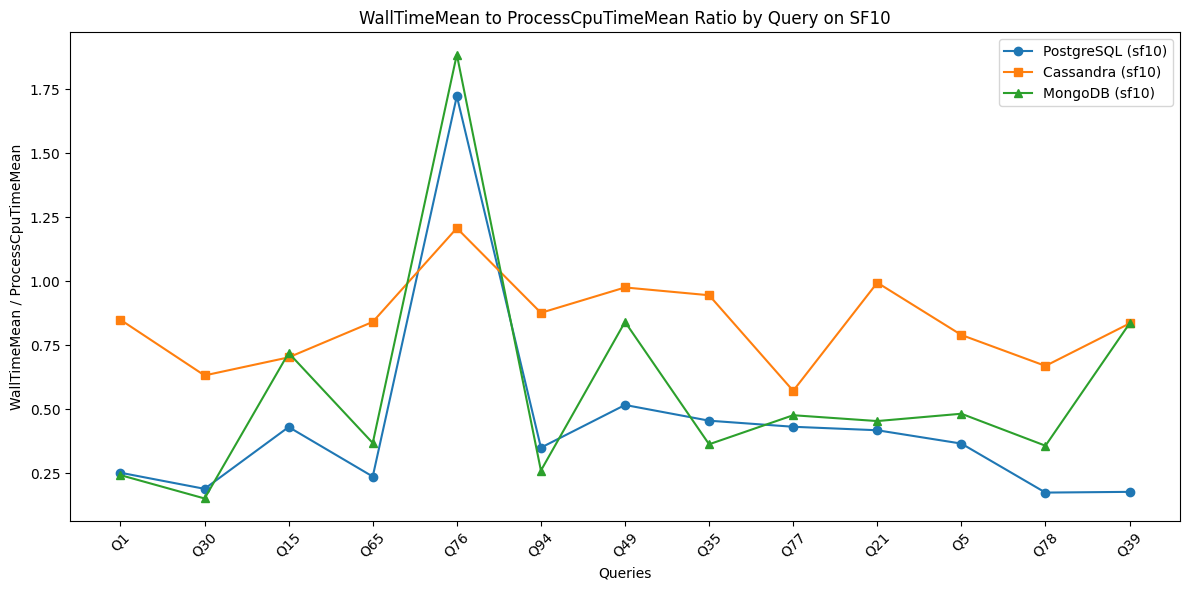

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data for Cassandra sf10
data_cassandra_sf10 = [
    {"suite": "tpcds_cassandra_sf10", "query": "Q1", "wallTimeMean": 51777, "processCpuTimeMean": 60930},
    {"suite": "tpcds_cassandra_sf10", "query": "Q30", "wallTimeMean": 22635, "processCpuTimeMean": 35786},
    {"suite": "tpcds_cassandra_sf10", "query": "Q15", "wallTimeMean": 112943, "processCpuTimeMean": 160650},
    {"suite": "tpcds_cassandra_sf10", "query": "Q65", "wallTimeMean": 498668, "processCpuTimeMean": 592556},
    {"suite": "tpcds_cassandra_sf10", "query": "Q76", "wallTimeMean": 473924, "processCpuTimeMean": 392416},
    {"suite": "tpcds_cassandra_sf10", "query": "Q94", "wallTimeMean": 131423, "processCpuTimeMean": 149860},
    {"suite": "tpcds_cassandra_sf10", "query": "Q49", "wallTimeMean": 459481, "processCpuTimeMean": 470756},
    {"suite": "tpcds_cassandra_sf10", "query": "Q35", "wallTimeMean": 416424, "processCpuTimeMean": 440356},
    {"suite": "tpcds_cassandra_sf10", "query": "Q77", "wallTimeMean": 31213, "processCpuTimeMean": 54533},
    {"suite": "tpcds_cassandra_sf10", "query": "Q21", "wallTimeMean": 568068, "processCpuTimeMean": 571070},
    {"suite": "tpcds_cassandra_sf10", "query": "Q5", "wallTimeMean": 537349, "processCpuTimeMean": 679733},
    {"suite": "tpcds_cassandra_sf10", "query": "Q78", "wallTimeMean": 452008, "processCpuTimeMean": 674950},
    {"suite": "tpcds_cassandra_sf10", "query": "Q39", "wallTimeMean": 1256764, "processCpuTimeMean": 1504230},
]

# Data for MongoDB sf10
data_mongodb_sf10 = [
    {"suite": "tpcds_mongodb_sf10", "query": "Q1", "wallTimeMean": 8165, "processCpuTimeMean": 33576},
    {"suite": "tpcds_mongodb_sf10", "query": "Q30", "wallTimeMean": 5102, "processCpuTimeMean": 33566},
    {"suite": "tpcds_mongodb_sf10", "query": "Q15", "wallTimeMean": 61525, "processCpuTimeMean": 85423},
    {"suite": "tpcds_mongodb_sf10", "query": "Q65", "wallTimeMean": 116953, "processCpuTimeMean": 317333},
    {"suite": "tpcds_mongodb_sf10", "query": "Q76", "wallTimeMean": 35650, "processCpuTimeMean": 18906},
    {"suite": "tpcds_mongodb_sf10", "query": "Q94", "wallTimeMean": 32568, "processCpuTimeMean": 124776},
    {"suite": "tpcds_mongodb_sf10", "query": "Q49", "wallTimeMean": 91673, "processCpuTimeMean": 108930},
    {"suite": "tpcds_mongodb_sf10", "query": "Q35", "wallTimeMean": 84766, "processCpuTimeMean": 233100},
    {"suite": "tpcds_mongodb_sf10", "query": "Q77", "wallTimeMean": 122235, "processCpuTimeMean": 256216},
    {"suite": "tpcds_mongodb_sf10", "query": "Q21", "wallTimeMean": 269292, "processCpuTimeMean": 592750},
    {"suite": "tpcds_mongodb_sf10", "query": "Q5", "wallTimeMean": 179211, "processCpuTimeMean": 371113},
    {"suite": "tpcds_mongodb_sf10", "query": "Q78", "wallTimeMean": 226252, "processCpuTimeMean": 632016},
    {"suite": "tpcds_mongodb_sf10", "query": "Q39", "wallTimeMean": 1256764, "processCpuTimeMean": 1504230},
]

# Data for PostgreSQL sf10
data_postgresql_sf10 = [
    {"suite": "tpcds_postgresql_sf10", "query": "Q1", "wallTimeMean": 6461, "processCpuTimeMean": 25586},
    {"suite": "tpcds_postgresql_sf10", "query": "Q30", "wallTimeMean": 5705, "processCpuTimeMean": 30083},
    {"suite": "tpcds_postgresql_sf10", "query": "Q15", "wallTimeMean": 18463, "processCpuTimeMean": 42836},
    {"suite": "tpcds_postgresql_sf10", "query": "Q65", "wallTimeMean": 51639, "processCpuTimeMean": 217333},
    {"suite": "tpcds_postgresql_sf10", "query": "Q76", "wallTimeMean": 21187, "processCpuTimeMean": 12296},
    {"suite": "tpcds_postgresql_sf10", "query": "Q94", "wallTimeMean": 20147, "processCpuTimeMean": 57490},
    {"suite": "tpcds_postgresql_sf10", "query": "Q49", "wallTimeMean": 42488, "processCpuTimeMean": 82153},
    {"suite": "tpcds_postgresql_sf10", "query": "Q35", "wallTimeMean": 38708, "processCpuTimeMean": 84930},
    {"suite": "tpcds_postgresql_sf10", "query": "Q77", "wallTimeMean": 56585, "processCpuTimeMean": 130976},
    {"suite": "tpcds_postgresql_sf10", "query": "Q21", "wallTimeMean": 164251, "processCpuTimeMean": 392553},
    {"suite": "tpcds_postgresql_sf10", "query": "Q5", "wallTimeMean": 63776, "processCpuTimeMean": 174090},
    {"suite": "tpcds_postgresql_sf10", "query": "Q78", "wallTimeMean": 93995, "processCpuTimeMean": 537126},
    {"suite": "tpcds_postgresql_sf10", "query": "Q39", "wallTimeMean": 186836, "processCpuTimeMean": 1050643},
]

# Convert to DataFrames
df_cassandra_sf10 = pd.DataFrame(data_cassandra_sf10)
df_mongodb_sf10 = pd.DataFrame(data_mongodb_sf10)
df_postgresql_sf10 = pd.DataFrame(data_postgresql_sf10)

# Calculate the ratios
df_cassandra_sf10['ratio'] = df_cassandra_sf10['wallTimeMean'] / df_cassandra_sf10['processCpuTimeMean']
df_mongodb_sf10['ratio'] = df_mongodb_sf10['wallTimeMean'] / df_mongodb_sf10['processCpuTimeMean']
df_postgresql_sf10['ratio'] = df_postgresql_sf10['wallTimeMean'] / df_postgresql_sf10['processCpuTimeMean']

# Plot the data
queries = df_cassandra_sf10['query']
x = range(len(queries))

plt.figure(figsize=(12, 6))
plt.plot(x, df_postgresql_sf10['ratio'], label='PostgreSQL (sf10)', marker='o')
plt.plot(x, df_cassandra_sf10['ratio'], label='Cassandra (sf10)', marker='s')
plt.plot(x, df_mongodb_sf10['ratio'], label='MongoDB (sf10)', marker='^')


plt.xticks(x, queries, rotation=45)
plt.xlabel('Queries')
plt.ylabel('WallTimeMean / ProcessCpuTimeMean')
plt.title('WallTimeMean to ProcessCpuTimeMean Ratio by Query on SF10')
plt.legend()
plt.tight_layout()
plt.show()
